In [1]:
import numpy as np
import pickle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

## Data functions

In [3]:
def load_input_data(input_data):
    """
    Return input data as numpy array of [x-coordinate, y-coordinate]
    """
    
    # parse the input
    lines = input_data.split('\n')

    num_nodes = int(lines[0])

    nodes_array = np.zeros((num_nodes, 2))
    for i in range(num_nodes):
        line = lines[i+1]
        parts = line.split()
        nodes_array[i,:] = np.array([float(parts[0]), float(parts[1])])
        
    return nodes_array, num_nodes


In [4]:
# 33810
input_file = open('data/tsp_200_1','r').read()

In [5]:
nodes_array, num_nodes = load_input_data(input_file)
nodes_array

array([[1380.,  939.],
       [2848.,   96.],
       [3510., 1671.],
       [ 457.,  334.],
       [3888.,  666.],
       [ 984.,  965.],
       [2721., 1482.],
       [1286.,  525.],
       [2716., 1432.],
       [ 738., 1325.],
       [1251., 1832.],
       [2728., 1698.],
       [3815.,  169.],
       [3683., 1533.],
       [1247., 1945.],
       [ 123.,  862.],
       [1234., 1946.],
       [ 252., 1240.],
       [ 611.,  673.],
       [2576., 1676.],
       [ 928., 1700.],
       [  53.,  857.],
       [1807., 1711.],
       [ 274., 1420.],
       [2574.,  946.],
       [ 178.,   24.],
       [2678., 1825.],
       [1795.,  962.],
       [3384., 1498.],
       [3520., 1079.],
       [1256.,   61.],
       [1424., 1728.],
       [3913.,  192.],
       [3085., 1528.],
       [2573., 1969.],
       [ 463., 1670.],
       [3875.,  598.],
       [ 298., 1513.],
       [3479.,  821.],
       [2542.,  236.],
       [3955., 1743.],
       [1323.,  280.],
       [3447., 1830.],
       [293

In [6]:
def prepare_output_data(solution_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """

    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)

    output_data = str(solution_dict['tour_distance']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution_dict['solution_array']))

    return output_data

In [118]:
prepare_output_data(solution_dict)

'34169.21045841982 0\n181 177 108 37 23 17 115 162 87 15 21 93 150 143 52 165 78 136 83 128 9 117 148 89 48 5 192 62 103 0 159 27 92 57 176 179 60 24 80 101 134 68 167 129 188 140 158 102 172 88 168 41 30 79 55 199 132 144 96 180 196 3 64 65 195 25 186 151 110 183 147 69 18 191 109 74 198 118 113 91 7 156 135 173 66 50 86 105 8 6 56 146 130 166 61 163 119 154 141 34 85 26 11 19 54 82 121 33 107 174 153 161 182 171 29 170 137 127 138 47 187 197 13 2 45 28 42 189 133 124 116 157 70 40 99 155 51 77 95 104 4 142 36 185 38 149 84 67 72 122 43 169 175 190 49 193 194 81 94 12 32 75 1 120 39 63 53 164 76 112 178 59 114 22 97 90 126 184 44 31 100 152 14 16 10 139 46 111 145 71 20 73 58 123 131 35 160 125 98 106'

## Distance matrix functions

In [ ]:
## consider sklearn.neighbors.KDTree in future to get k nearest neighbours in O(n log n) 
## rather than the O(n^2) distance matrix

In [7]:
def make_distance_matrix(nodes_array):
    
    return squareform(pdist(nodes_array, 'euclidean'))

In [8]:
distance_matrix = make_distance_matrix(nodes_array)
distance_matrix

array([[   0.        , 1692.82987923, 2252.27085405, ..., 2431.94263913,
         552.63731325,  762.16533639],
       [1692.82987923,    0.        , 1708.46978317, ..., 1696.89716836,
        2079.33282569, 1899.31382346],
       [2252.27085405, 1708.46978317,    0.        , ...,  260.22490273,
        2804.2403606 , 2893.77331524],
       ...,
       [2431.94263913, 1696.89716836,  260.22490273, ...,    0.        ,
        2980.46053488, 3039.95016407],
       [ 552.63731325, 2079.33282569, 2804.2403606 , ..., 2980.46053488,
           0.        ,  437.77619853],
       [ 762.16533639, 1899.31382346, 2893.77331524, ..., 3039.95016407,
         437.77619853,    0.        ]])

## KD tree functions

A KD tree can give us the k nearest neighbours in O(n log n) time rather than O(n^2), very useful for large problems.

In [9]:
def make_kd_tree(nodes_array):
    
    return cKDTree(nodes_array)

In [22]:
kd_tree = make_kd_tree(nodes_array)

In [58]:
%timeit kd_tree.query(nodes_array[0],k=2,p=2)

122 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
kd_tree.query(nodes_array[0],k=2,p=2)

(array([   0., 2000.]), array([    0, 33800]))

In [59]:
%timeit distance_matrix[5304,7084]

334 ns ± 6.45 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Route traversing functions

Can be done with either a distance matrix or a kd-tree

In [11]:
def traverse_route_dist_mat(route_array, distance_matrix):
    
    first_index = route_array
    second_index = np.concatenate((route_array[1:],  np.array([route_array[0]])))
        
    return sum(distance_matrix[first_index, second_index])

In [14]:
traverse_route_dist_mat(solution_array, distance_matrix)

36861.3862594383

In [60]:
#def traverse_route_kd_tree(route_array, kd_tree):

In [24]:
a = np.array([[0, 2],
              [1, 3],
              [5, 6]])
a[:,0].max()

5

## Nearest point with randomisation greedy algorithm

In [12]:
def greedy_tour(distance_matrix, num_nodes, start_node_index = None, 
                second_best_greedy_probability = 0):
    
    # copy distance matrix
    function_distance_matrix = np.copy(distance_matrix)
    
    # get max from distance matrix + 1
    max_distance_p1 = np.max(function_distance_matrix) + 1
    
    # initialise solution array
    solution = []
    
    # if start_node_index isn't given pick one randomly
    if start_node_index is None:
        start_node_index = np.random.randint(num_nodes)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution.append(node_index)
    
    # loop until we have no unused indexes left
    while len(solution) < num_nodes:
        
        # put the used indexes values (the column) up to the max + 1 so we don't visit nodes already visited
        function_distance_matrix[:, node_index].fill(max_distance_p1)
        
        # choose the next index based on shortest distance to next node, occasionally taking second 
        # closest with probability second_best_greedy_probability
        min_indexes = np.argpartition(function_distance_matrix[node_index, :], 2)[:2]
        min_indexes_sorted = min_indexes[np.argsort(function_distance_matrix[node_index, :][min_indexes])]       
        if np.random.rand() < second_best_greedy_probability and len(solution) < num_nodes - 2:
            next_index = min_indexes_sorted[1]
        else: 
            next_index = min_indexes_sorted[0]

        # append the index to the solution
        solution.append(next_index)
        
        # set the node index to next index
        node_index = next_index

    return np.array(solution)

In [13]:
solution_array = greedy_tour(distance_matrix, num_nodes, start_node_index = 0, 
                             second_best_greedy_probability = 0.000)
solution_array

array([  0, 103,  62, 192,   5,  48,  89, 148, 117,   9, 128,  83, 136,
        23,  37, 108, 177, 181,  98, 125,  35, 160, 131, 123,  58,  73,
        20, 145,  71, 111,  46, 139,  31, 184,  44,  90,  97, 126,  22,
       114, 112, 178,  59,  61, 163, 119, 154, 141,  34,  85,  26,  11,
        19, 146, 130, 166,  76, 164, 179,  60,  24,  80, 101, 134,  68,
       167, 129, 188, 140, 158, 102, 172,  88, 168,  41,  30,  79,  55,
       199, 132, 144,  96, 180, 196,   3,  64,  65, 195,  25, 186, 151,
       110, 183, 147,  69,  21,  15,  87, 143, 162, 115,  17,  78, 165,
        52,  18, 191, 109,  74, 198, 118, 113,  91,   7, 156, 135, 173,
       159,  27,  92,  57, 176,  50,  86, 105,   8,   6,  56, 153, 174,
        82,  54, 107, 121,  33,  28,  45,   2,  42, 189, 133, 124, 116,
        13, 197, 187,  47, 127, 138, 137, 170,  29, 171, 182, 161,  84,
        67,  72, 122,  43, 169, 175, 190,  49, 193, 194, 149,  38, 185,
       104,   4, 142,  36,  77,  51, 155,  95,  99,  70, 157,  4

In [17]:
def get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, array, k=10, ith_nearest=1):

    indexes_array = np.array([])
    
    while len(indexes_array) < ith_nearest:
        kd_output = kd_tree.query(node_array[node_index], k=k, p=2)
        indexes_mask = (~np.isin(kd_output[1], array))
        indexes_array = np.arange(k)[indexes_mask]
        k *= 2
        
    return kd_output[1][indexes_array[ith_nearest-1]]

In [74]:
get_nearest_neighbour_not_in_array(nodes_array, 8, kd_tree, np.array([0,8]), k=10, ith_nearest=1)

18

In [16]:
def greedy_tour_kd(kd_tree, node_array, num_nodes, start_node_index = None, 
                   second_best_greedy_probability = 0):
    
    # initialise solution array
    solution_array = np.empty([num_nodes])
    
    # if start_node_index isn't given pick one randomly
    if start_node_index is None:
        start_node_index = np.random.randint(num_nodes)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution_array[0] = node_index
    
    #distance = 0
    
    k = 5
    
    # loop until we have no unused indexes left
    for counter in range(1, num_nodes):
        
        if second_best_greedy_probability == 0: 
            next_node_index = get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, 
                                                                 solution_array, k=k, ith_nearest=1)
        else:
            if np.random.rand() < second_best_greedy_probability:
                next_node_index = get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, 
                                                                     solution_array, k=k, ith_nearest=2)
            else:
                 next_node_index = get_nearest_neighbour_not_in_array(node_array, node_index, kd_tree, 
                                                                 solution_array, k=k, ith_nearest=1)
            
        solution_array[counter] = next_node_index
        #distance += next_dist

        # set the node index to next index
        node_index = next_node_index
    

    return solution_array.astype(int)

In [44]:
%time greedy_tour_kd(kd_tree, nodes_array, num_nodes, start_node_index = 0)

Wall time: 1min 38s


array([0.0000e+00, 8.0000e+00, 7.0000e+00, ..., 1.6982e+04, 1.7340e+04,
       1.7334e+04])

In [48]:
kd_tree.query(nodes_array[8], k=10, p=2)

(array([   0.        , 2000.        , 2000.        , 2000.        ,
        2113.2025459 , 2828.42712475, 2828.42712475, 4000.        ,
        4000.        , 4000.        ]),
 array([    8,     0,    18,     7,  1316, 33809,    17,     6,    28,
        33800]))

In [24]:
#s = greedy_tour_kd(kd_tree, nodes_array, num_nodes, start_node_index = 0)
#s

In [29]:
def get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 100,
                         start_node_index = None, 
                         second_best_greedy_probability = 0):
    
    best_solution = greedy_tour(distance_matrix, num_nodes, start_node_index = start_node_index, 
                                second_best_greedy_probability = second_best_greedy_probability)
    best_distance = traverse_route_dist_mat(best_solution, distance_matrix)
    
    for run in range(num_runs-1):
        solution = greedy_tour(distance_matrix, num_nodes, start_node_index = start_node_index, 
                               second_best_greedy_probability = second_best_greedy_probability)
        distance = traverse_route_dist_mat(solution, distance_matrix)
        if distance < best_distance:
            best_solution = solution
            best_distance = distance
            
    solution_dict = {
        'solution_array': best_solution,
        'tour_distance': best_distance
    }
            
    return solution_dict

In [30]:
solution_dict = get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 1000,
                                     start_node_index = None, 
                                     second_best_greedy_probability = 0.005)
solution_dict

{'solution_array': array([111,  46, 139,  31, 184,  44,  90,  97, 126,  22, 114, 112, 178,
         59,  61, 163, 119, 154, 141,  34,  85,  26,  11,  19, 146, 130,
        166,  76, 164, 179,  60,  24,  80, 101, 134,  68, 167, 129, 188,
        140, 158, 102, 172,  88, 168,  41,  30,  79,  55, 199, 132, 144,
         96, 180, 196,   3,  64,  65, 195,  25, 186, 151, 110, 183, 147,
         69,  21,  15,  87, 143, 162, 115,  17,  23,  37, 160,  35, 125,
         98, 177, 108, 181, 106, 131, 123,  58,  73,  20, 145,  71, 128,
          9, 117, 148,  89,  48,   5, 192,  62, 103,   0, 159,  27,  92,
         57, 176,  50,  86, 105,   8,   6,  56, 153, 174,  82,  54, 107,
        121,  33,  28,  45,   2, 189,  42, 124, 116, 133, 157,  70,  40,
         99, 197,  13, 187,  47, 127, 138, 137, 170,  29, 171, 182, 161,
         84,  67,  72, 122,  43, 169, 175, 190,  49, 193, 194, 149,  38,
        185, 104,   4, 142,  36,  77,  51, 155,  95,  32,  75,  12,  94,
         81,   1, 120,  39,  63, 

In [96]:
## could make sure to not make crossings

34420.21076908056

## 2-opt

In [ ]:
def greedy_tour_without_crossing(distance_matrix, num_nodes, start_node_index = None, 
                                 second_best_greedy_probability = 0,
                                 third_best_greedy_probability = 0):
    
    # copy distance matrix
    function_distance_matrix = np.copy(distance_matrix)
    
    # get max from distance matrix + 1
    max_distance_p1 = np.max(function_distance_matrix) + 1
    
    # initialise solution array
    solution = []
    
    # if start_node_index isn't given pick one randomly
    if start_node_index is None:
        start_node_index = np.random.randint(num_nodes)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution.append(node_index)
    
    # loop until we have no unused indexes left
    while len(solution) < num_nodes:
        
        # put the used indexes values (the column) up to the max + 1 so we don't visit nodes already visited
        function_distance_matrix[:, node_index].fill(max_distance_p1)
        
        # choose the next index based on shortest distance to next node, occasionally taking second 
        # closest with probability second_best_greedy_probability
        min_indexes = np.argpartition(function_distance_matrix[node_index, :], 2)[:2]
        min_indexes_sorted = min_indexes[np.argsort(function_distance_matrix[node_index, :][min_indexes])]       
        if np.random.rand() < second_best_greedy_probability and len(solution) < num_nodes - 2:
            next_index = min_indexes_sorted[1]
        else: 
            next_index = min_indexes_sorted[0]

        # append the index to the solution
        solution.append(next_index)
        
        # set the node index to next index
        node_index = next_index

    return np.array(solution)

In [36]:
for i in range(1000):
    print(i*np.log(i))

nan
0.0
1.3862943611198906
3.295836866004329
5.545177444479562
8.047189562170502
10.75055681536833
13.621371043387192
16.635532333438686
19.775021196025975
23.02585092994046
26.376848000782076
29.818879797456006
33.34434164699998
36.94680261461362
40.62075301653315
44.3614195558365
48.16462684895568
52.02669164213096
55.94434060416236
59.914645471079815
63.93497119219188
68.00293397388296
72.11636696637044
76.2732919283507
80.47189562170502
84.71050998855854
88.9875953821169
93.30172628490571
97.65157906960775
102.03592144986466
106.45360333903953
110.90354888959125
115.38474952839385
119.89625783694949
124.43718215212947
129.00668178441995
133.6039627678363
138.22827406960266
142.8789041990562
147.55517816455745
152.25645473487663
156.9821239679015
161.73160497482317
166.50434389240348
171.29981203966437
176.11750423849838
180.95693728037276
185.81764852357878
190.6991946074207
195.6011502714073
200.5231072689406
205.46467336623422
210.42547141826248
215.40513851447082
220.40332518778

c:\repos\coursera_discrete_optimization\venv-disc-opt\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
c:\repos\coursera_discrete_optimization\venv-disc-opt\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [38]:
36000*np.log(36000)

377685.8718277769

## Visualise solution

In [31]:
def plot_tour(nodes_array, distance_matrix, solution_dict):
    
    solution_array = solution_dict['solution_array']
    distance = solution_dict['tour_distance']
    
    num_nodes = nodes_array.shape[0]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Optimized tour')
    ax.scatter(nodes_array[:, 0], nodes_array[:, 1])
    start_node = solution_array[0]
    #distance = 0.
    for i in range(num_nodes):
        start_pos = nodes_array[start_node]
        next_node = solution_array[i] 
        end_pos = nodes_array[next_node]
        ax.annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
        #distance += distance_matrix[start_node, next_node] 
        start_node = next_node
        
    ax.annotate("",
                xy=end_pos, xycoords='data',
                xytext=nodes_array[solution_array[0]], textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    #distance += distance_matrix[next_node, solution_array[0]]

    textstr = "N nodes: %d\nTotal length: %.3f" % (num_nodes, distance)
    plt.title(textstr)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.tight_layout()
    plt.show()

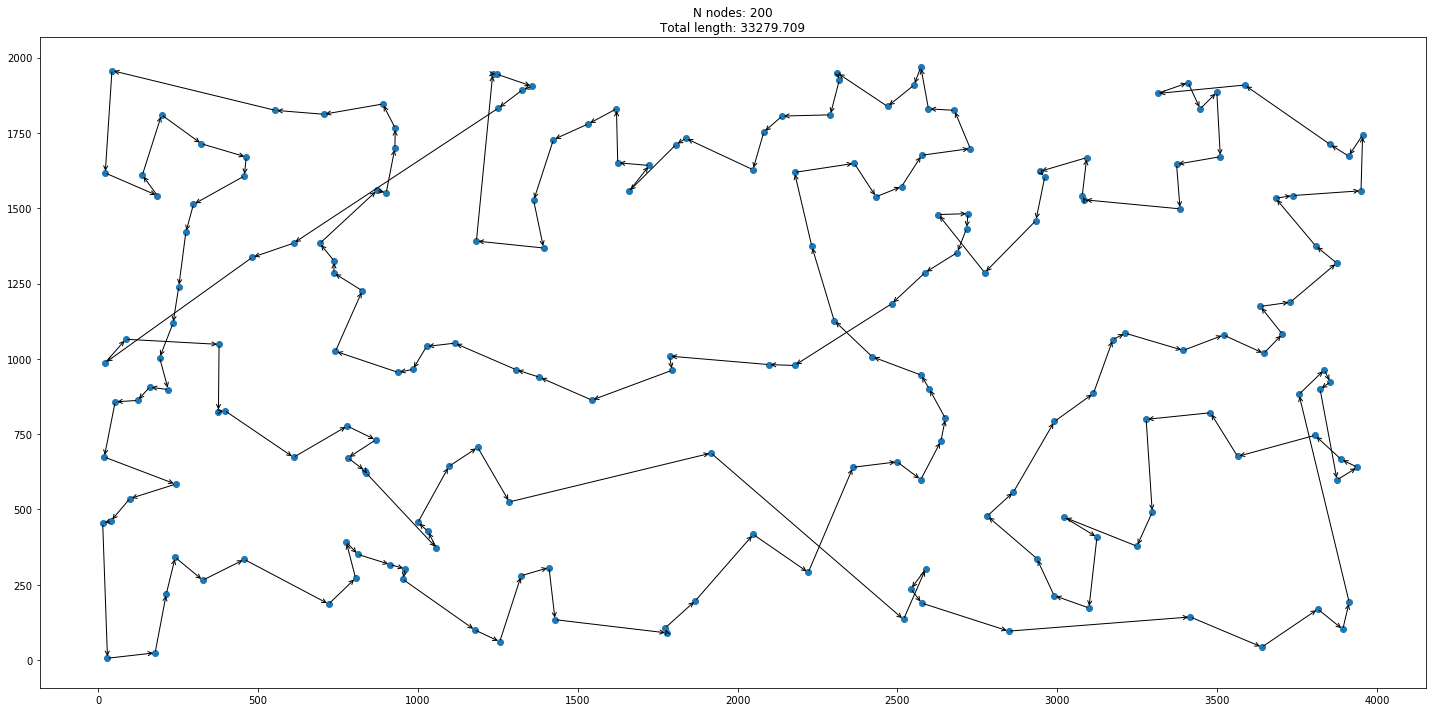

In [32]:
plot_tour(nodes_array, distance_matrix, solution_dict)